# Video Super Resolution
### Classical Upsampling vs. SRCNN (Deep Learning) — Frame-by-Frame Pipeline

This notebook builds a complete video super resolution pipeline:

1. **Data pipeline** — downsample frames as LR input, HR as ground truth
2. **Classical baselines** — nearest neighbour, bicubic, Lanczos
3. **SRCNN** — Super Resolution CNN in PyTorch (Dong et al., 2014)
4. **Quantitative evaluation** — PSNR & SSIM across all methods
5. **Video processing** — frame-by-frame inference, video reconstruction

---
**Dependencies:**
```
pip install torch torchvision numpy scipy matplotlib scikit-image opencv-python Pillow
```

In [8]:
# ── Download assets from GitHub (Colab setup) ─────────────────────────────────
import os
if not os.path.exists('clip.mp4'):
    !wget -q https://raw.githubusercontent.com/preeti-chauhan/video-super-resolution/main/clip.mp4
    print('Downloaded clip.mp4')
print('Assets ready.')

Assets ready.


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from skimage import data as skdata, color, transform
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from skimage.transform import resize, rescale
import cv2
import os
import warnings
warnings.filterwarnings('ignore')

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {DEVICE}')
print(f'PyTorch: {torch.__version__}')

Device: cuda
PyTorch: 2.10.0+cu128


---
## 1 · Data Pipeline

We use a real video clip (`clip.mp4`, 4K forest nature footage) as HR reference frames.

Pipeline:
1. Extract Y (luminance) channel from frames for training (standard SRCNN approach)
2. Downsample x SCALE_FACTOR to LR; bicubic-upsample back to HR size as SRCNN input
3. Extract overlapping 33x33 patches into SRDataset
4. 80/10/10 train/val/test split
5. For video output: SRCNN on Y channel + bicubic Cb/Cr → full color output

Loaded 180 frames — Y shape: (360, 640)


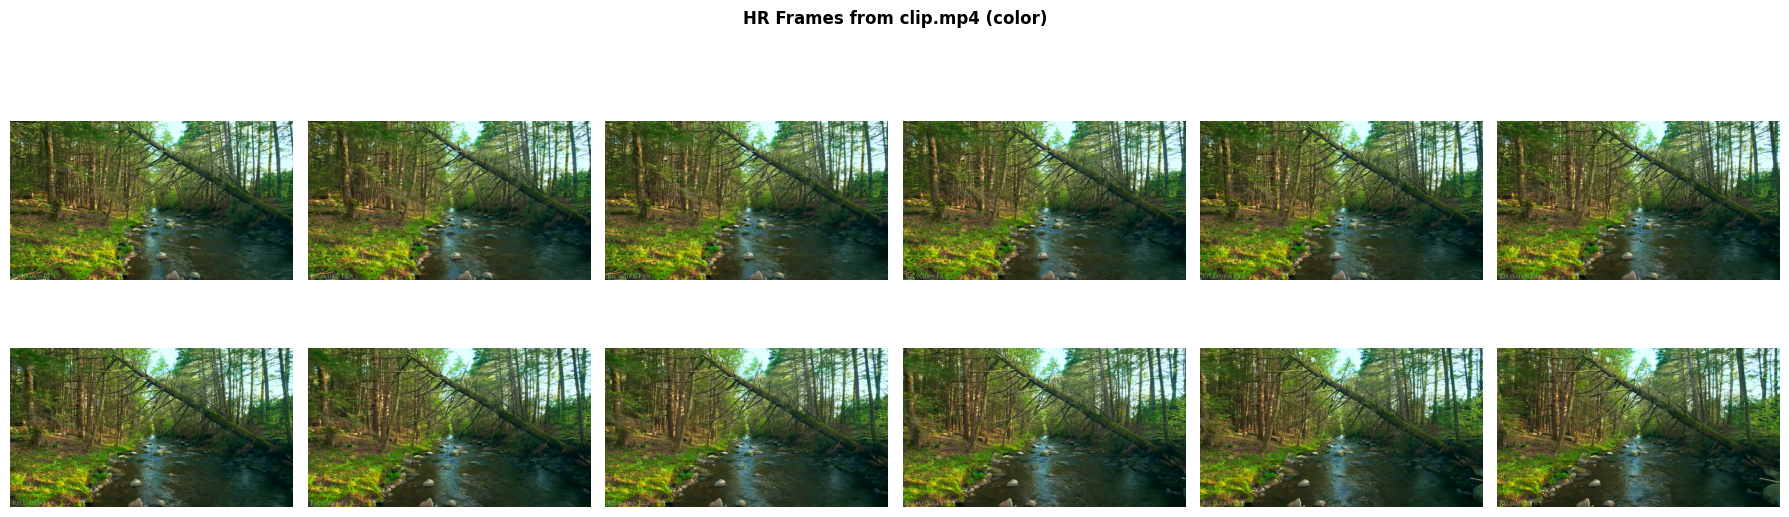

In [10]:
# ── Parameters ────────────────────────────────────────────────────────────────
SCALE_FACTOR  = 3       # ← tune: 2, 3, or 4 (upscaling factor)
PATCH_SIZE    = 33      # ← tune: SRCNN input patch size (must be odd)
STRIDE        = 14      # ← tune: patch extraction stride
BATCH_SIZE    = 64
NUM_EPOCHS    = 30      # ← tune: increase for better results
LR            = 1e-4

VIDEO_PATH = 'clip.mp4'

def load_frames_from_video(path):
    """Extract Y (luminance) channel for training + BGR color frames for visualization."""
    cap = cv2.VideoCapture(path)
    y_frames    = []   # grayscale Y channel — used for training
    bgr_frames  = []   # full color — used for video output
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        ycbcr = cv2.cvtColor(frame, cv2.COLOR_BGR2YCrCb).astype(np.float32) / 255.0
        y_frames.append(ycbcr[:, :, 0])
        bgr_frames.append(frame)
    cap.release()
    return y_frames, bgr_frames

hr_frames, bgr_frames = load_frames_from_video(VIDEO_PATH)
print(f'Loaded {len(hr_frames)} frames — Y shape: {hr_frames[0].shape}')

# Preview 12 evenly-spaced color frames
idxs = [int(i * len(bgr_frames) / 12) for i in range(12)]
fig, axes = plt.subplots(2, 6, figsize=(18, 6))
for ax, idx in zip(axes.flat, idxs):
    ax.imshow(cv2.cvtColor(bgr_frames[idx], cv2.COLOR_BGR2RGB))
    ax.axis('off')
fig.suptitle('HR Frames from clip.mp4 (color)', fontweight='bold')
plt.tight_layout()
plt.show()

In [11]:
class SRDataset(Dataset):
    """
    Extracts overlapping patches from (LR_bicubic, HR) pairs.
    SRCNN is trained on patches to keep memory manageable.
    """
    def __init__(self, lr_frames, hr_frames, patch_size=33, stride=14):
        self.lr_patches = []
        self.hr_patches = []

        for lr, hr in zip(lr_frames, hr_frames):
            H, W = hr.shape
            for r in range(0, H - patch_size + 1, stride):
                for c in range(0, W - patch_size + 1, stride):
                    self.lr_patches.append(lr[r:r+patch_size, c:c+patch_size])
                    self.hr_patches.append(hr[r:r+patch_size, c:c+patch_size])

    def __len__(self):
        return len(self.lr_patches)

    def __getitem__(self, idx):
        lr = torch.from_numpy(self.lr_patches[idx]).unsqueeze(0)
        hr = torch.from_numpy(self.hr_patches[idx]).unsqueeze(0)
        return lr, hr

# ── Generate LR/HR pairs ──────────────────────────────────────────────────────
def make_lr_hr_pairs(frames, scale):
    """Downsample HR frames to LR, then bicubic-upsample back to HR size."""
    lr_frames = []
    for hr in frames:
        H, W = hr.shape
        lr_small = rescale(hr, 1.0 / scale, anti_aliasing=True, order=3).astype(np.float32)
        lr_up    = resize(lr_small, (H, W), order=3, anti_aliasing=True).astype(np.float32)
        lr_frames.append(lr_up)
    return lr_frames

# ── Train / val / test split (144 frames: 80% / 10% / 10%) ───────────────────
n       = len(hr_frames)
n_train = int(n * 0.8)
n_val   = int(n * 0.1)

train_hr = hr_frames[:n_train]
val_hr   = hr_frames[n_train:n_train + n_val]
test_hr  = hr_frames[n_train + n_val:]

train_lr = make_lr_hr_pairs(train_hr, SCALE_FACTOR)
val_lr   = make_lr_hr_pairs(val_hr,   SCALE_FACTOR)
test_lr  = make_lr_hr_pairs(test_hr,  SCALE_FACTOR)

train_ds = SRDataset(train_lr, train_hr, PATCH_SIZE, STRIDE)
val_ds   = SRDataset(val_lr,   val_hr,   PATCH_SIZE, STRIDE)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f'Train frames: {len(train_hr)} | Val frames: {len(val_hr)} | Test frames: {len(test_hr)}')
print(f'Train patches: {len(train_ds)} | Val patches: {len(val_ds)}')

Train frames: 144 | Val frames: 18 | Test frames: 18
Train patches: 152064 | Val patches: 19008


---
## 2 · Classical Upsampling Baselines

| Method | Order | Characteristic |
|---|---|---|
| Nearest neighbour | 0 | Fastest; blocky artefacts |
| Bilinear | 1 | Smooth but blurry |
| Bicubic | 3 | Standard baseline for SR |
| Lanczos | 5 | Sharpest classical method |

=== Classical Baselines (scale ×3) ===
Method          PSNR (dB)     SSIM
------------------------------------
Nearest             22.92   0.6686
Bilinear            23.15   0.6549
Bicubic             23.66   0.6985
Lanczos             23.69   0.7022


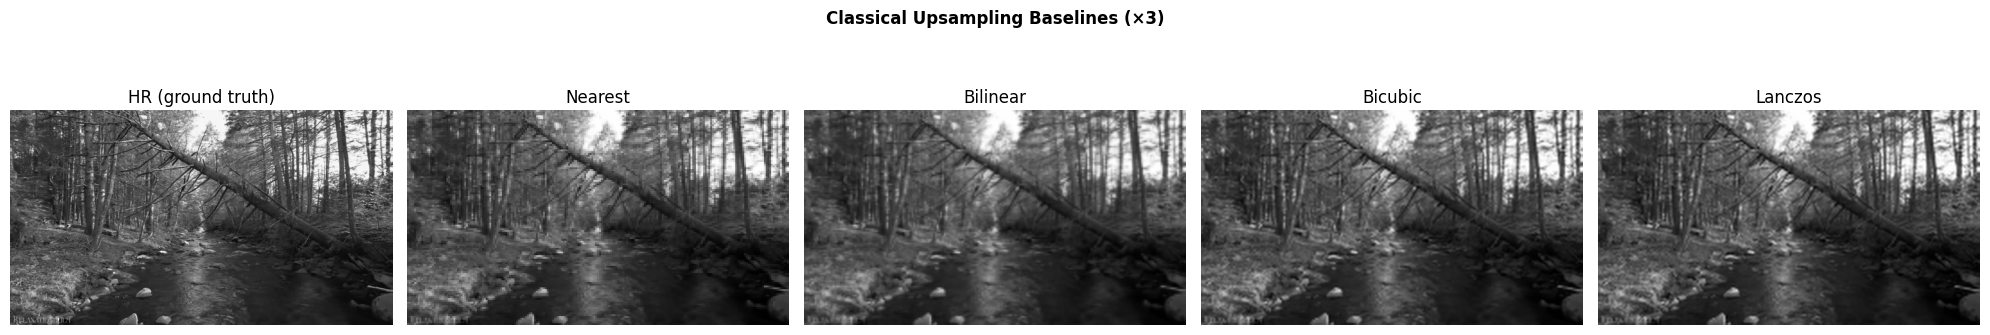

In [12]:
def classical_upsample(hr, scale):
    """Downsample HR, then upsample with each classical method."""
    lr_small = rescale(hr, 1.0 / scale, anti_aliasing=True, order=3)
    target   = hr.shape
    return {
        'Nearest':  resize(lr_small, target, order=0).astype(np.float32),
        'Bilinear': resize(lr_small, target, order=1).astype(np.float32),
        'Bicubic':  resize(lr_small, target, order=3).astype(np.float32),
        'Lanczos':  resize(lr_small, target, order=5).astype(np.float32),
    }

def compute_metrics(ref, candidate):
    p = psnr(ref, candidate, data_range=1.0)
    s = ssim(ref, candidate, data_range=1.0)
    return p, s

# Evaluate on first test frame
hr_test  = test_hr[0]
upscaled = classical_upsample(hr_test, SCALE_FACTOR)

print(f'=== Classical Baselines (scale ×{SCALE_FACTOR}) ===')
print(f'{"Method":<14} {"PSNR (dB)":>10} {"SSIM":>8}')
print('-' * 36)
for name, img in upscaled.items():
    p, s = compute_metrics(hr_test, img)
    print(f'{name:<14} {p:>10.2f} {s:>8.4f}')

# Visualize
imgs   = [hr_test, *upscaled.values()]
titles = ['HR (ground truth)', *upscaled.keys()]
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for ax, img, title in zip(axes, imgs, titles):
    ax.imshow(img, cmap='gray')
    ax.set_title(title)
    ax.axis('off')
fig.suptitle(f'Classical Upsampling Baselines (×{SCALE_FACTOR})', fontweight='bold')
plt.tight_layout()
plt.show()

---
## 3 · SRCNN — Super Resolution CNN

**SRCNN** (Dong et al., 2014) is the pioneering CNN for image super resolution.
It maps a bicubic-upsampled LR image directly to HR using three conv layers:

| Layer | Kernel | Filters | Role |
|---|---|---|---|
| Conv1 | 9×9 | 64 | Patch extraction & representation |
| Conv2 | 1×1 | 32 | Non-linear mapping |
| Conv3 | 5×5 | 1  | Reconstruction |

In [13]:
class SRCNN(nn.Module):
    """SRCNN: Learning a Deep Convolutional Network for Image Super-Resolution.
    Dong et al., ECCV 2014 / IEEE TPAMI 2015.
    """
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=9, padding=4)   # patch extraction
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)  # non-linear mapping
        self.conv3 = nn.Conv2d(32, 1,  kernel_size=5, padding=2)  # reconstruction
        self.relu  = nn.ReLU(inplace=True)
        self._init_weights()

    def _init_weights(self):
        for layer in [self.conv1, self.conv2]:
            nn.init.normal_(layer.weight, mean=0, std=0.001)
            nn.init.zeros_(layer.bias)
        nn.init.normal_(self.conv3.weight, mean=0, std=0.001)
        nn.init.zeros_(self.conv3.bias)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

model = SRCNN().to(DEVICE)
total_params = sum(p.numel() for p in model.parameters())
print(f'SRCNN parameters: {total_params:,}')
print(model)

SRCNN parameters: 8,129
SRCNN(
  (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU(inplace=True)
)


---
## 4 · Training Pipeline

Epoch [  5/30]  Train: 0.004085  Val: 0.003918  LR: 1.00e-04
Epoch [ 10/30]  Train: 0.003979  Val: 0.003838  LR: 1.00e-04
Epoch [ 15/30]  Train: 0.003963  Val: 0.003823  LR: 5.00e-05
Epoch [ 20/30]  Train: 0.003955  Val: 0.003817  LR: 5.00e-05
Epoch [ 25/30]  Train: 0.003944  Val: 0.003806  LR: 5.00e-05
Epoch [ 30/30]  Train: 0.003936  Val: 0.003799  LR: 2.50e-05


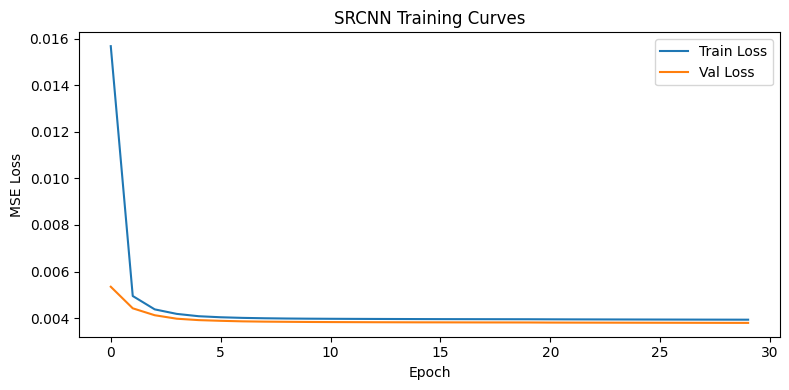

Best val loss: 0.003799


In [14]:
criterion = nn.MSELoss()
# SRCNN paper uses different LRs per layer
optimizer = optim.Adam([
    {'params': model.conv1.parameters(), 'lr': LR},
    {'params': model.conv2.parameters(), 'lr': LR},
    {'params': model.conv3.parameters(), 'lr': LR * 0.1},  # smaller LR for last layer
])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)

train_losses, val_losses = [], []
best_val_loss = float('inf')

for epoch in range(NUM_EPOCHS):
    # ── Train ──────────────────────────────────────────────────────────────────
    model.train()
    t_loss = 0.0
    for lr_patch, hr_patch in train_loader:
        lr_patch, hr_patch = lr_patch.to(DEVICE), hr_patch.to(DEVICE)
        optimizer.zero_grad()
        sr_patch = model(lr_patch)
        loss = criterion(sr_patch, hr_patch)
        loss.backward()
        optimizer.step()
        t_loss += loss.item()

    # ── Validate ───────────────────────────────────────────────────────────────
    model.eval()
    v_loss = 0.0
    with torch.no_grad():
        for lr_patch, hr_patch in val_loader:
            lr_patch, hr_patch = lr_patch.to(DEVICE), hr_patch.to(DEVICE)
            sr_patch = model(lr_patch)
            v_loss += criterion(sr_patch, hr_patch).item()

    t_loss /= len(train_loader)
    v_loss /= len(val_loader)
    train_losses.append(t_loss)
    val_losses.append(v_loss)
    scheduler.step()

    # Save best model
    if v_loss < best_val_loss:
        best_val_loss = v_loss
        torch.save(model.state_dict(), 'srcnn_best.pth')

    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1:>3}/{NUM_EPOCHS}]  Train: {t_loss:.6f}  Val: {v_loss:.6f}  LR: {scheduler.get_last_lr()[0]:.2e}')

# ── Load best weights & plot ───────────────────────────────────────────────────
model.load_state_dict(torch.load('srcnn_best.pth', map_location=DEVICE))

plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('SRCNN Training Curves')
plt.legend()
plt.tight_layout()
plt.show()
print(f'Best val loss: {best_val_loss:.6f}')

---
## 5 · Evaluation — Classical vs. SRCNN

In [15]:
def srcnn_upscale(model, lr_bicubic):
    """Run SRCNN inference on a full bicubic-upsampled frame."""
    model.eval()
    with torch.no_grad():
        t = torch.from_numpy(lr_bicubic).unsqueeze(0).unsqueeze(0).to(DEVICE)
        out = model(t).squeeze().cpu().numpy()
    return np.clip(out, 0, 1).astype(np.float32)

print(f'=== Super Resolution Benchmark (×{SCALE_FACTOR}) ===')
print(f'{"Method":<14} {"PSNR (dB)":>10} {"SSIM":>8}')
print('-' * 36)

all_results = {}
for hr, lr_bic in zip(test_hr, test_lr):
    methods = {**classical_upsample(hr, SCALE_FACTOR), 'SRCNN': srcnn_upscale(model, lr_bic)}
    for name, img in methods.items():
        p, s = compute_metrics(hr, img)
        all_results.setdefault(name, []).append((p, s))

for name, scores in all_results.items():
    avg_p = np.mean([s[0] for s in scores])
    avg_s = np.mean([s[1] for s in scores])
    marker = ' ◀ best' if name == 'SRCNN' else ''
    print(f'{name:<14} {avg_p:>10.2f} {avg_s:>8.4f}{marker}')

=== Super Resolution Benchmark (×3) ===
Method          PSNR (dB)     SSIM
------------------------------------
Nearest             23.10   0.6760
Bilinear            23.37   0.6638
Bicubic             23.91   0.7076
Lanczos             23.95   0.7115
SRCNN               24.35   0.7491 ◀ best


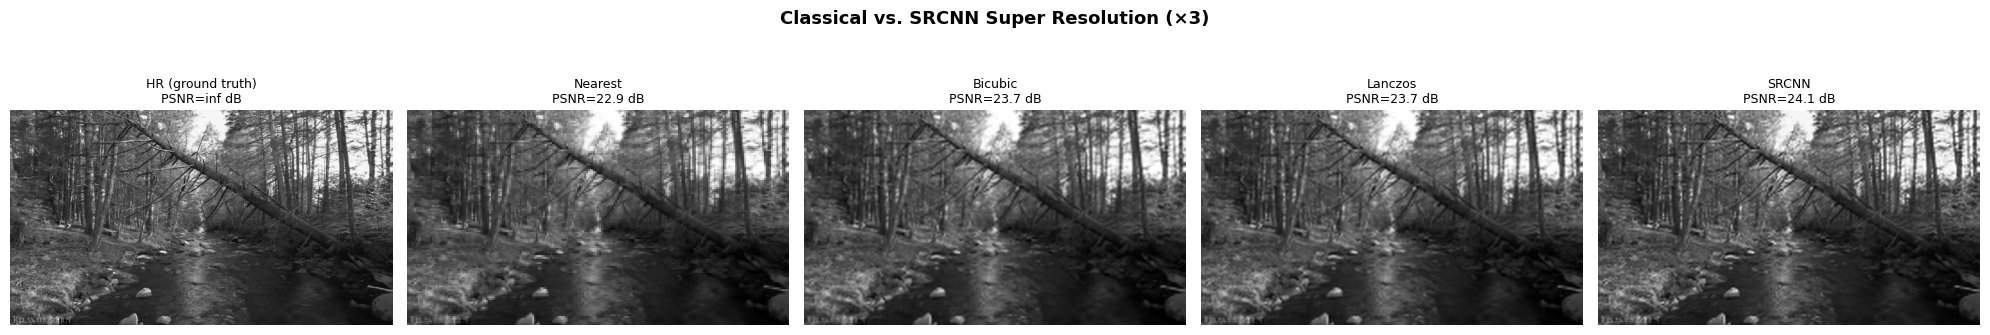

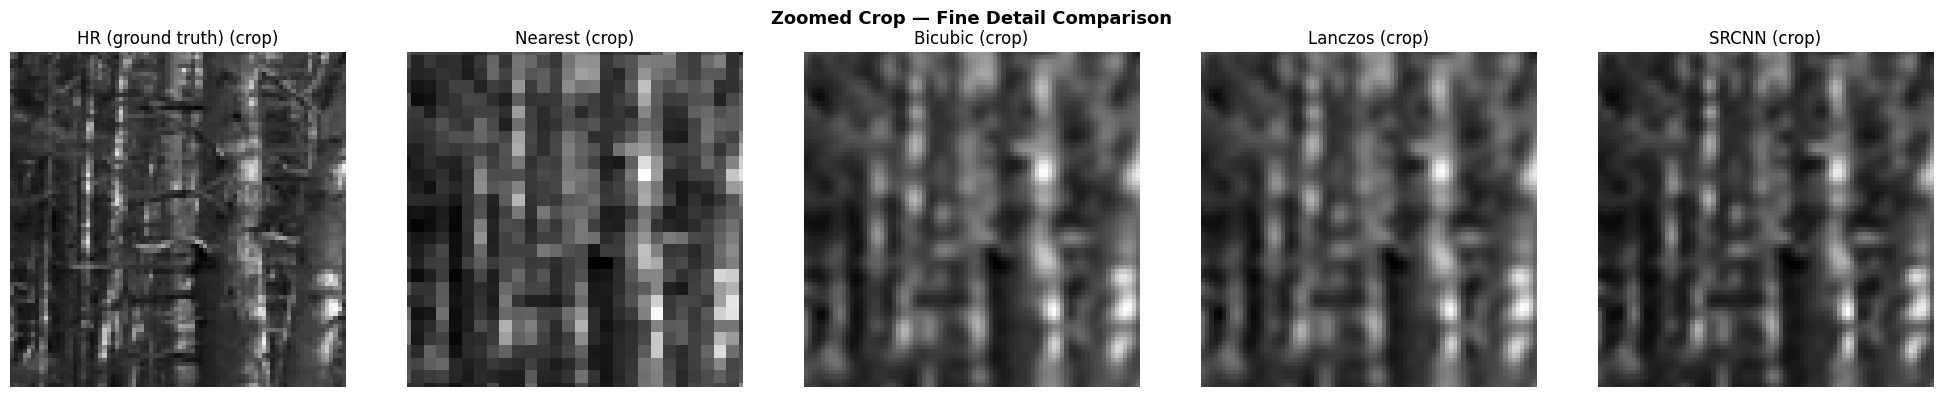

In [16]:
# ── Visual comparison ─────────────────────────────────────────────────────────
hr_test  = test_hr[0]
lr_bic   = test_lr[0]
upscaled = classical_upsample(hr_test, SCALE_FACTOR)
sr_out   = srcnn_upscale(model, lr_bic)

imgs   = [hr_test, upscaled['Nearest'], upscaled['Bicubic'], upscaled['Lanczos'], sr_out]
titles = ['HR (ground truth)', 'Nearest', 'Bicubic', 'Lanczos', 'SRCNN']

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for ax, img, title in zip(axes, imgs, titles):
    p, s = compute_metrics(hr_test, img)
    ax.imshow(img, cmap='gray')
    ax.set_title(f'{title}\nPSNR={p:.1f} dB', fontsize=9)
    ax.axis('off')
fig.suptitle(f'Classical vs. SRCNN Super Resolution (×{SCALE_FACTOR})', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

# ── Zoomed crop comparison ────────────────────────────────────────────────────
r, c, s = 80, 80, 80   # ← tune: crop region
crops  = [img[r:r+s, c:c+s] for img in imgs]
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for ax, crop, title in zip(axes, crops, titles):
    ax.imshow(crop, cmap='gray', interpolation='nearest')
    ax.set_title(f'{title} (crop)')
    ax.axis('off')
fig.suptitle('Zoomed Crop — Fine Detail Comparison', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 6 · Video Super Resolution Pipeline

LR video saved: synthetic_lr.mp4  (213x120 @ 30.0fps)


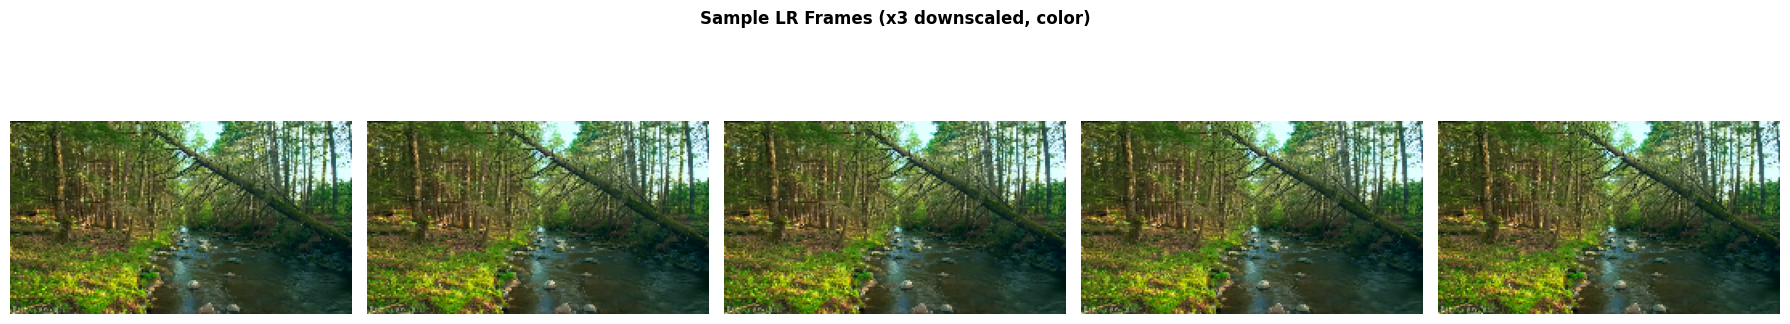

In [17]:
# ── Generate LR video from clip.mp4 (color) ──────────────────────────────────
SYNTHETIC_VIDEO = 'synthetic_lr.mp4'
SR_VIDEO        = 'sr_output.mp4'

cap = cv2.VideoCapture(VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS)
W   = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H   = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
W_lr, H_lr = W // SCALE_FACTOR, H // SCALE_FACTOR
cap.release()

tmp_lr = '/tmp/lr_raw.mp4'
out_lr = cv2.VideoWriter(tmp_lr, cv2.VideoWriter_fourcc(*'mp4v'), fps, (W_lr, H_lr), isColor=True)

lr_preview = []
cap = cv2.VideoCapture(VIDEO_PATH)
while True:
    ret, frame = cap.read()
    if not ret:
        break
    lr_small = cv2.resize(frame, (W_lr, H_lr), interpolation=cv2.INTER_CUBIC)
    out_lr.write(lr_small)
    if len(lr_preview) < 5:
        lr_preview.append(cv2.cvtColor(lr_small, cv2.COLOR_BGR2RGB))
cap.release()
out_lr.release()

os.system(f'ffmpeg -y -i {tmp_lr} -vcodec libx264 -crf 23 -pix_fmt yuv420p {SYNTHETIC_VIDEO} -loglevel quiet')
print(f'LR video saved: {SYNTHETIC_VIDEO}  ({W_lr}x{H_lr} @ {fps}fps)')

# Preview
fig, axes = plt.subplots(1, 5, figsize=(18, 4))
for ax, frame in zip(axes, lr_preview):
    ax.imshow(frame); ax.axis('off')
fig.suptitle(f'Sample LR Frames (x{SCALE_FACTOR} downscaled, color)', fontweight='bold')
plt.tight_layout()
plt.show()

SR video saved: sr_output.mp4  (180 frames @ 636x360, color)


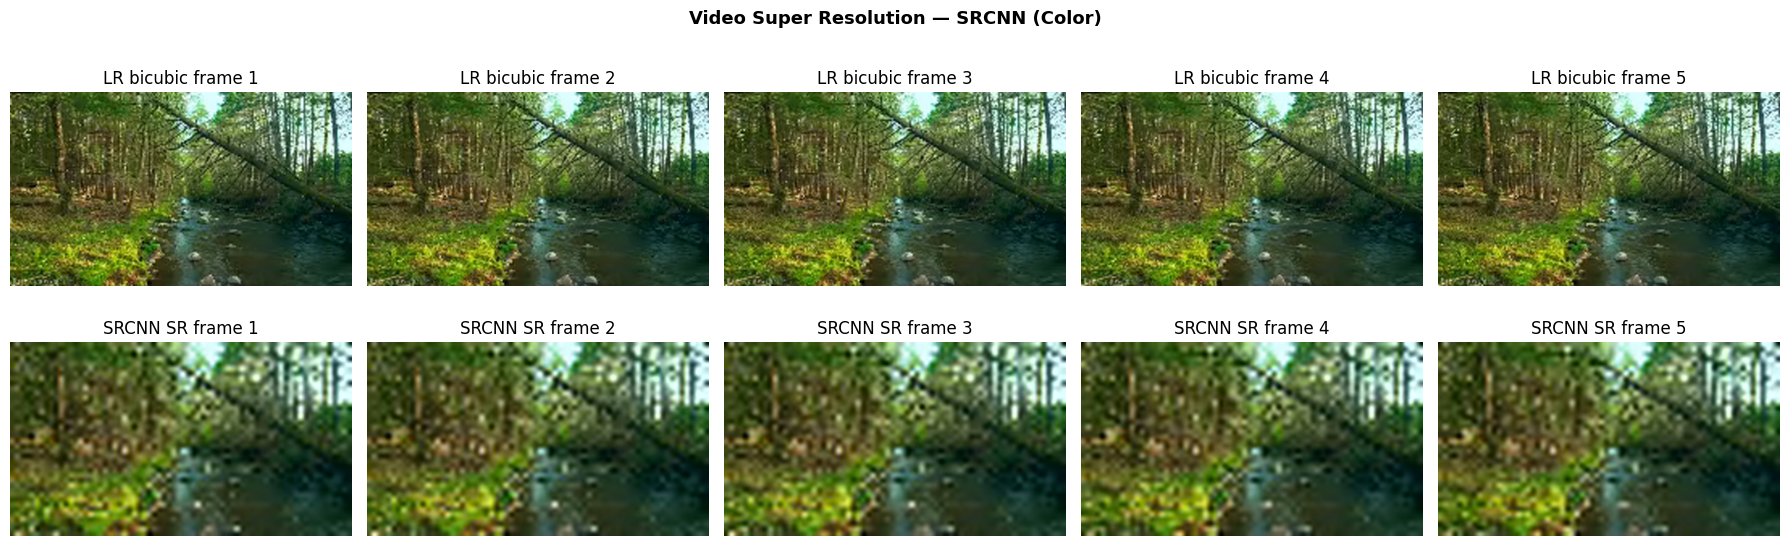

In [18]:
def srcnn_upscale_color(model, bgr_frame, scale):
    """
    Apply SRCNN on Y channel, bicubic upsample Cb/Cr, merge for full color output.
    Input:  BGR frame (uint8)
    Output: BGR frame (uint8) at scale x resolution
    """
    H, W = bgr_frame.shape[:2]
    W_hr, H_hr = W * scale, H * scale

    # Convert to YCbCr float
    ycbcr = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2YCrCb).astype(np.float32) / 255.0
    y, cr, cb = ycbcr[:,:,0], ycbcr[:,:,1], ycbcr[:,:,2]

    # Bicubic upsample Y for SRCNN input
    y_lr_up = cv2.resize(cv2.resize(y, (W//scale, H//scale), interpolation=cv2.INTER_CUBIC),
                         (W_hr, H_hr), interpolation=cv2.INTER_CUBIC)

    # SRCNN on Y channel
    y_sr = srcnn_upscale(model, y_lr_up)

    # Bicubic upsample Cb and Cr
    cr_up = cv2.resize(cr, (W_hr, H_hr), interpolation=cv2.INTER_CUBIC)
    cb_up = cv2.resize(cb, (W_hr, H_hr), interpolation=cv2.INTER_CUBIC)

    # Merge and convert back to BGR
    ycbcr_hr = np.stack([y_sr, cr_up, cb_up], axis=2)
    bgr_hr   = cv2.cvtColor((np.clip(ycbcr_hr, 0, 1) * 255).astype(np.uint8), cv2.COLOR_YCrCb2BGR)
    return bgr_hr

def super_resolve_video(input_path, output_path, model, scale):
    """Read LR color video, apply SRCNN super resolution, write color HR MP4 output."""
    cap   = cv2.VideoCapture(input_path)
    fps   = cap.get(cv2.CAP_PROP_FPS)
    W_lr  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    H_lr  = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    W_hr, H_hr = W_lr * scale, H_lr * scale

    tmp_out = '/tmp/sr_raw.mp4'
    out = cv2.VideoWriter(tmp_out, cv2.VideoWriter_fourcc(*'mp4v'), fps, (W_hr, H_hr), isColor=True)

    lr_preview = []
    sr_preview = []
    model.eval()

    for i in range(total):
        ret, frame = cap.read()
        if not ret:
            break
        sr_frame = srcnn_upscale_color(model, frame, scale)
        out.write(sr_frame)
        if i < 5:
            lr_preview.append(cv2.cvtColor(cv2.resize(frame, (W_hr, H_hr), interpolation=cv2.INTER_CUBIC), cv2.COLOR_BGR2RGB))
            sr_preview.append(cv2.cvtColor(sr_frame, cv2.COLOR_BGR2RGB))

    cap.release()
    out.release()
    os.system(f'ffmpeg -y -i {tmp_out} -vcodec libx264 -crf 23 -pix_fmt yuv420p {output_path} -loglevel quiet')
    print(f'SR video saved: {output_path}  ({total} frames @ {W_hr}x{H_hr}, color)')
    return lr_preview, sr_preview

lr_preview, sr_preview = super_resolve_video(SYNTHETIC_VIDEO, SR_VIDEO, model, SCALE_FACTOR)

# ── Visualize sample frames (color) ──────────────────────────────────────────
fig, axes = plt.subplots(2, 5, figsize=(18, 6))
for i in range(5):
    axes[0, i].imshow(lr_preview[i])
    axes[0, i].set_title(f'LR bicubic frame {i+1}')
    axes[0, i].axis('off')
    axes[1, i].imshow(sr_preview[i])
    axes[1, i].set_title(f'SRCNN SR frame {i+1}')
    axes[1, i].axis('off')
fig.suptitle('Video Super Resolution — SRCNN (Color)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 7 · Save & Load Model

In [19]:
torch.save(model.state_dict(), 'srcnn_weights.pth')
print('Model saved to srcnn_weights.pth')

# ── Load (example) ────────────────────────────────────────────────────────────
# model_loaded = SRCNN().to(DEVICE)
# model_loaded.load_state_dict(torch.load('srcnn_weights.pth', map_location=DEVICE))
# model_loaded.eval()

Model saved to srcnn_weights.pth
